In [2]:
# imports
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score, confusion_matrix
import pandas as pd

In [3]:
# load data
sample_recording = False
all_data = loadmat('data/sample_1.mat')
sample_data = np.array(all_data['data'])

sample_data = np.array([np.load('data/recording.npy')])
print(sample_data.shape)

# extract spike times for later comparison
spike_times = np.array(all_data['spike_times'])
print('# of actual spikes (ground truth):', len(spike_times[0][0][0]))

(1, 61000192)
# of actual spikes (ground truth): 3214


In [4]:
# parameters
seconds = 120
sr = 32051 # sample rate = 24kHz (For sample recordings) / 32051 for real recording

data = sample_data[0][:round(seconds*sr)]
ground_truth_spikes = spike_times[0][0][0][:round(seconds*sr)]

mean_data = np.mean(data)
std_data = np.std(data)


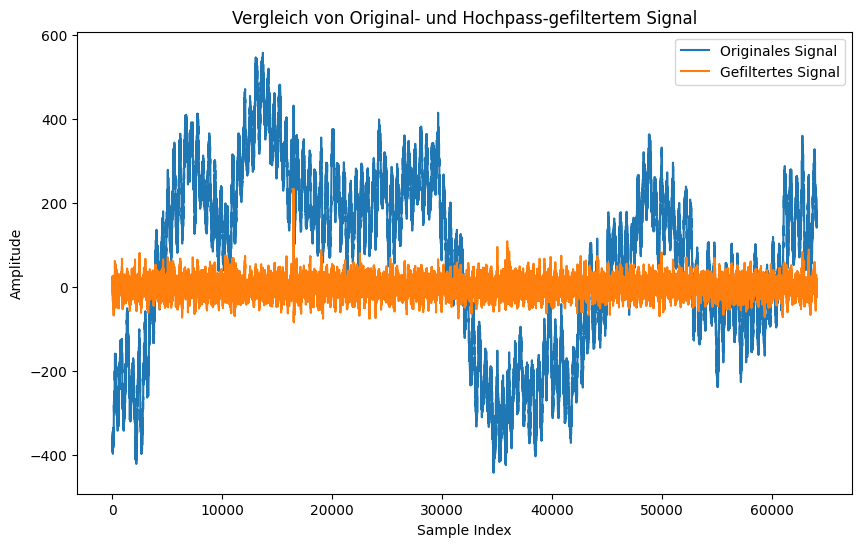

In [5]:
from scipy.signal import butter, filtfilt

cutoff = 70  
order = 5

# Filterfunktion erstellen
def highpass_filter(data, cutoff, fs, order=3):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data)
    return y

sample_data = highpass_filter(data, cutoff=cutoff, fs=sr, order=order)

# Visualisierung des gefilterten Signals
plt.figure(figsize=(10, 6))
plt.plot(data[:sr * 2], label='Originales Signal')
plt.plot(sample_data[:sr * 2], label='Gefiltertes Signal')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('Vergleich von Original- und Hochpass-gefiltertem Signal')
plt.show()

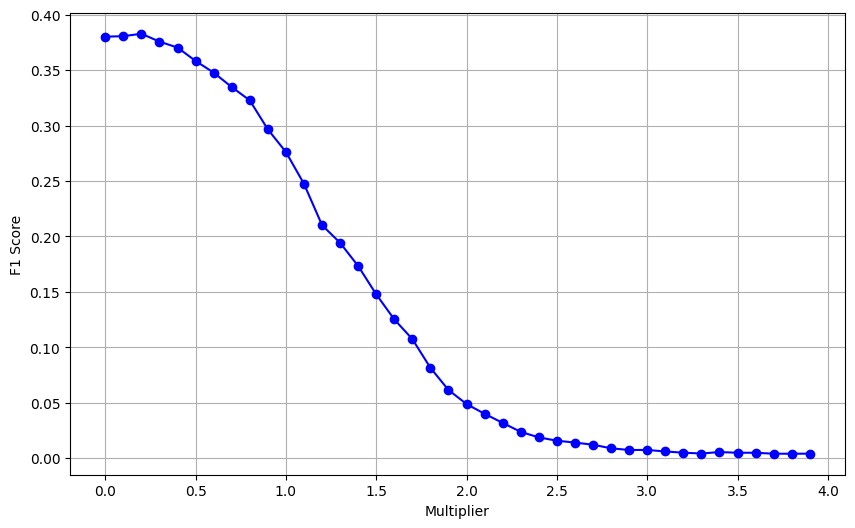

Best multiplier: 0.2, F1 score: 0.3828272071441673
                 Predicted No Spike  Predicted Spike
Actual No Spike             2286390             1748
Actual Spike                1554817             3165


In [6]:
def detect_spikes(data, multiplier):
    spike_times_start_only = []
    spike_times_reconstructed = np.where(data >= np.mean(data) + multiplier * np.std(data))[0]
    
    if len(spike_times_reconstructed) > 0:
        spike_times_start_only.append(spike_times_reconstructed[0])
        spike_times_start_only.extend(spike_times_reconstructed[np.where(np.diff(spike_times_reconstructed) > 10)[0]+1])

    return np.array(spike_times_start_only)


def calculate_f1_score(detected_spikes, ground_truth_spikes, sr, tolerance=0.01):
    # convert tolerance (time duration in seconds: 0.001 = 1ms) to number of samples
    tolerance_in_samples = tolerance * sr
    detected_binary = np.zeros_like(data)

    # set values to 1 where spikes occur (detected_binary[start_index:end_index] = 1)
    for spike in (detected_spikes / sr):
        detected_binary[int(spike * sr - tolerance_in_samples): int(spike * sr + tolerance_in_samples)] = 1

    ground_truth_binary = np.zeros_like(data)
    for spike in (ground_truth_spikes / sr):
        ground_truth_binary[int(spike * sr - tolerance_in_samples): int(spike * sr + tolerance_in_samples)] = 1

    # calculate F1 score
    f1 = f1_score(ground_truth_binary, detected_binary)

    # confusion matrix
    conf_matrix = confusion_matrix(ground_truth_binary, detected_binary)
    
    return f1, conf_matrix


# test different multiplier values for threshold
multipliers = np.arange(0.0, 4.0, 0.1) 
f1_scores = []
best_f1, best_conf = 0, None

for multiplier in multipliers:
    detected_spikes = detect_spikes(data, multiplier)
    f1, conf = calculate_f1_score(detected_spikes, spike_times[0][0][0][:round(seconds*sr)], sr)
    f1_scores.append(f1)

    if f1 > best_f1:
        best_conf = conf


# plot F1 scores as a function of the multiplier
plt.figure(figsize=(10, 6))
plt.plot(multipliers, f1_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Multiplier')
plt.ylabel('F1 Score')
plt.grid()
plt.show()

# get best multiplier based on F1 score
best_f1 = max(f1_scores)
best_multiplier = multipliers[np.argmax(f1_scores)]

# for better formatting
conf_df = pd.DataFrame(best_conf, index=["Actual No Spike", "Actual Spike"], columns=["Predicted No Spike", "Predicted Spike"])

print(f"Best multiplier: {best_multiplier}, F1 score: {best_f1}")
print(conf_df)

In [7]:
# apply threshold to raw data
spike_times_reconstructed = np.where(data >= mean_data + best_multiplier * std_data)[0]
print(mean_data + best_multiplier * std_data)
spike_times_start_only = []
spike_times_start_only.append(spike_times_reconstructed[0])
# if data is above threshold back to back, count all occurences as one single spike
spike_times_start_only.extend(spike_times_reconstructed[np.where(np.diff(spike_times_reconstructed) > 10)[0]+1])


108.19263375433263


In [8]:
# only runs this cell if seconds parameter is below 5, otherwise the plot gets too convoluted
if seconds < 5:
    # display data
    plt.figure(figsize=(25,6))
    plt.plot(np.linspace(0, seconds, round(seconds*sr)), data)
    plt.xlim(0, seconds)

    # plot where we think a spike is 
    for i, spike in enumerate(spike_times_start_only):
        # plt.axvline(spike/sr - .0008, c='red', alpha=0.5)
        plt.axvspan(spike/sr - .0008, spike/sr + .001, facecolor='r', alpha=0.2)
        plt.text(spike/sr - 0.006, 110 if i%2 == 0 else 100, i+1, c='r')

    # plot ground truth for reference
    for i, spike in enumerate(ground_truth_spikes / sr):
        if round(spike*24000) > round(seconds*24000): break
        plt.axvline(spike, c='k', alpha=1)
        plt.text(spike - 0.006, 85 if i%2 == 0 else 75, i+1, c='b')
        
    plt.show()

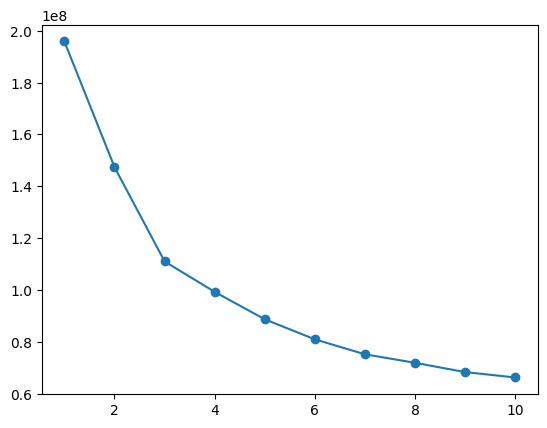

In [9]:
number_of_spikes = len(spike_times_start_only)

# get max & min voltage of all spikes (for plotting purposes)
ymax = 0
ymin = 0
spikes = []
detected_spike_times = []
for spike in spike_times_start_only:
    start = round(spike - .0008 * sr)
    end = round(spike + .001 * sr)
    if np.max(data[start:end]) > ymax: ymax = np.max(data[start:end])
    if np.min(data[start:end]) < ymin: ymin = np.min(data[start:end])
    # store detected spikes in list
    spikes.append(data[start:end])
    detected_spike_times.append(start)


if sample_recording:
    hit_or_miss = np.zeros(len(detected_spike_times))
    for i, spike in enumerate(detected_spike_times):
        matching = [x for x in spike_times[0][0][0] if spike - 10 <= x <= spike + 43]
        if matching:
            hit_or_miss[i] = 1
        else:
            hit_or_miss[i] = 0
    print(len(np.where(hit_or_miss == 1)[0])/len(spike_times[0][0][0]))
    
inertias = []
# determine best number of clusters via elbow plot
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init='auto')
    kmeans.fit(spikes)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.show()

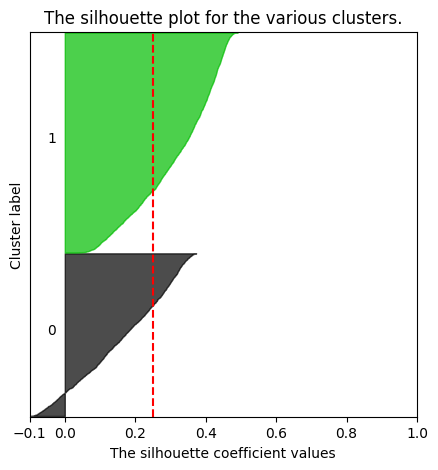

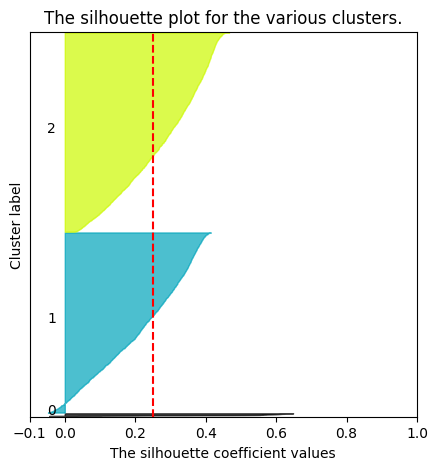

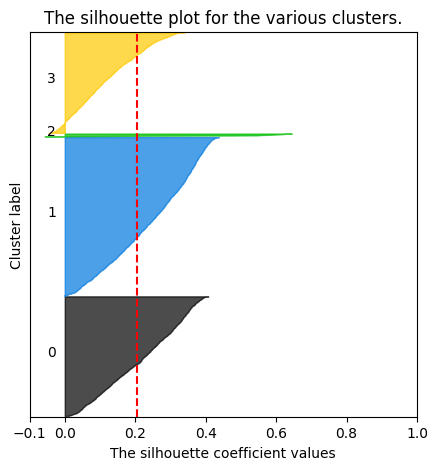

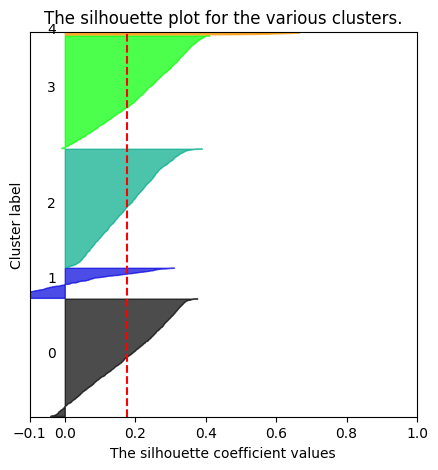

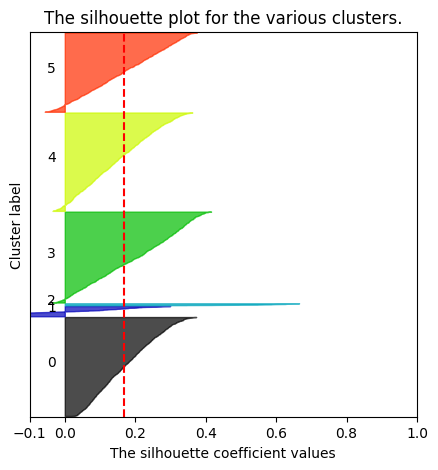

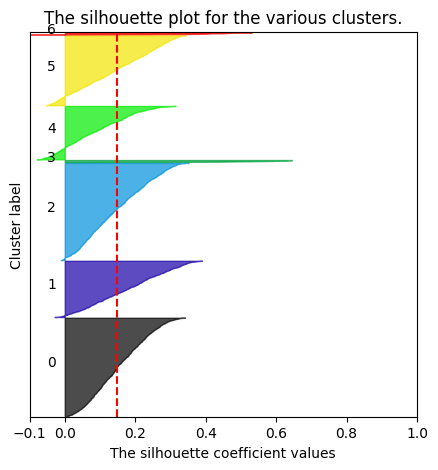

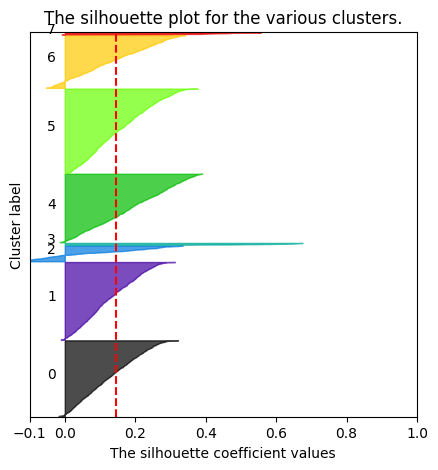

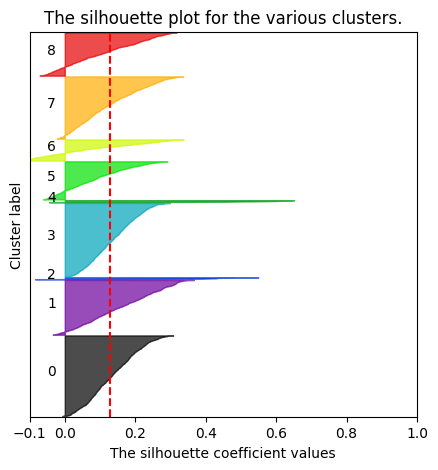

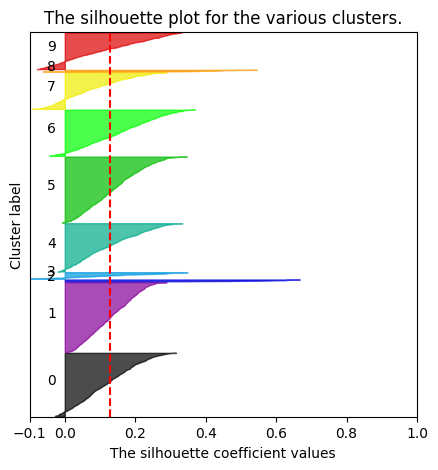

In [10]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [x for x in range(2, 11)]
for n_clusters in range_n_clusters:
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(5, 5)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(spikes) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, n_init="auto")
    cluster_labels = clusterer.fit_predict(spikes)
    silhouette_avg = silhouette_score(spikes, cluster_labels)

    sample_silhouette_values = silhouette_samples(spikes, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

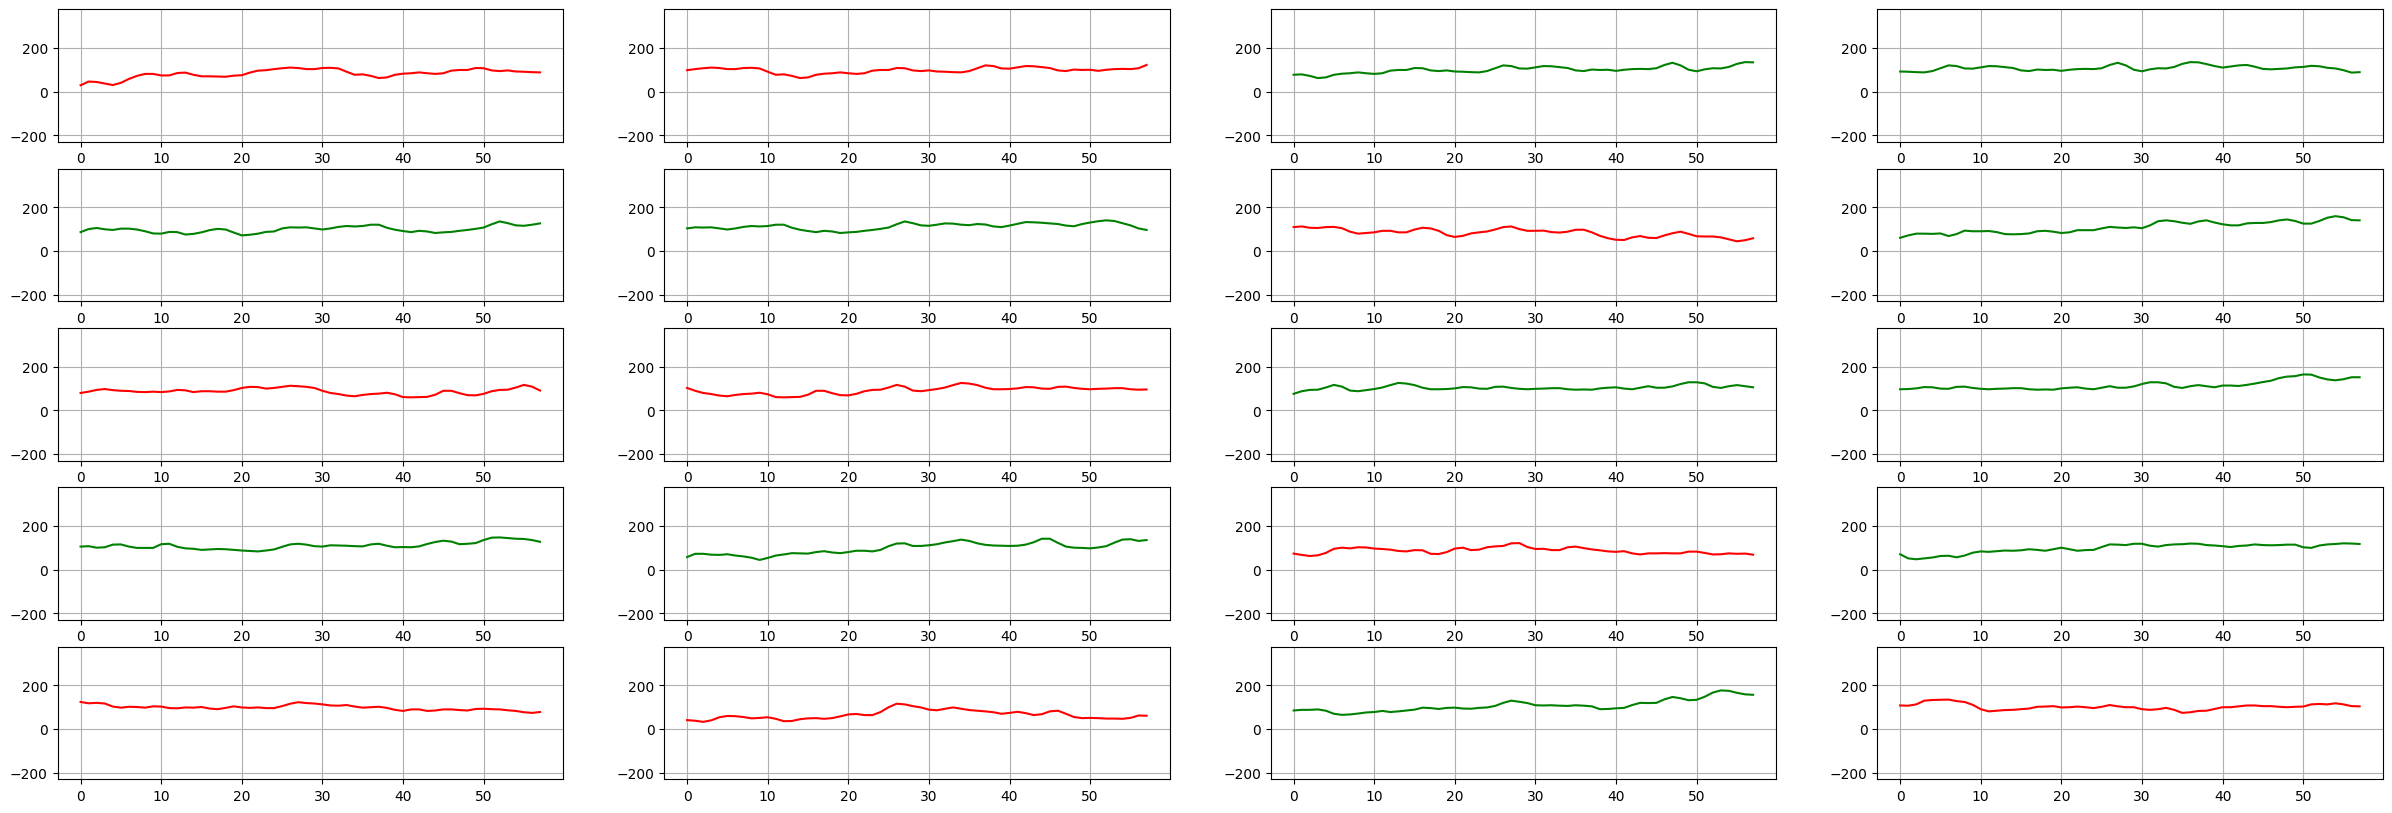

In [11]:
# apply final clustering algorithm based on optimal number of clusters
n_clusters = 3
kmeans_final = KMeans(n_init='auto', n_clusters=n_clusters)
classes = kmeans_final.fit_predict(spikes)
colors = ['r', 'g', 'b', 'orange']

# plot first 20 spikes in different colors to see if clustering worked
plt.figure(figsize=(30,10))
for i, spike in enumerate(spikes[:20]):
    plt.subplot(5, 4, i+1)
    plt.grid()
    plt.ylim(ymin, ymax)
    plt.plot(spike, c=colors[classes[i]])
plt.show()

# of spikes: 5395


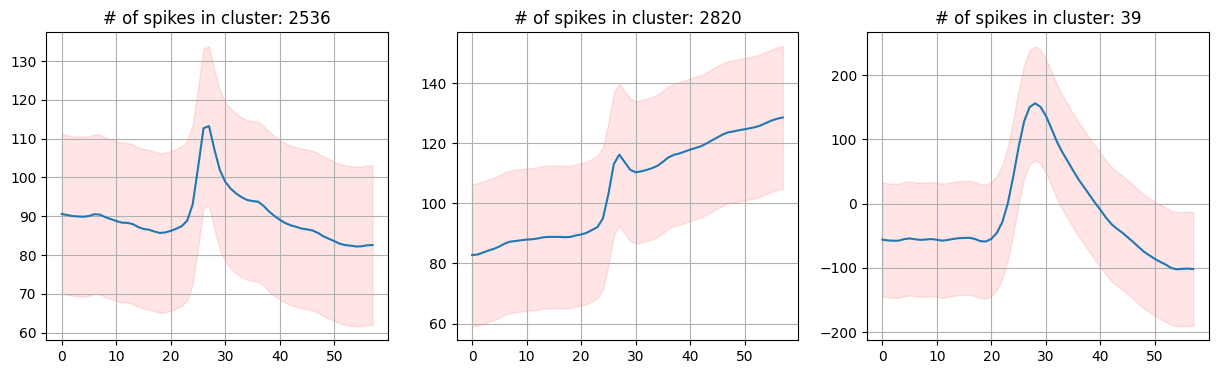

In [12]:
plt.figure(figsize=(5*n_clusters, 4))

print('# of spikes:', number_of_spikes)

# compute mean & std deviation of each spike class & plot them
for i in range(n_clusters):
    length = 43 if sample_recording else 58 # 43 for sr=24000, 58 for sr=32051
    x = np.arange(0, length, 1)
    classIndices = np.where(classes == i)[0]
    
    meanSpike = np.mean(np.array(spikes)[classIndices], axis=0)
    deviation = np.std(np.array(spikes)[classIndices])
    
    plt.subplot(1, n_clusters, i+1)
    plt.title(f'# of spikes in cluster: {len(classIndices)}')
    plt.plot(meanSpike)
    plt.fill_between(x, meanSpike - deviation, meanSpike + deviation, alpha=0.1, color='r')
    plt.grid()
plt.show()

# Gap Statistics Implementation 
source: Estimating the number of clusters in a data set via the gap statistic Robert Tibshirani, Guenther Walther and Trevor Hastie Stanford University
https://www.jstor.org/stable/2680607?seq=5


![How to calculate the gap statistics](./gap.png)

In [56]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist

# Step 1: Cluster the observed data
def calculate_within_dispersion(data, max_k):
    """
    Cluster the data for k = 1, ..., max_k and calculate within-dispersion measure Wk for each k.
    """
    Wk = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42).fit(data)
        # Sum of squared distances to the nearest cluster center
        Wk.append(np.sum(np.min(cdist(data, kmeans.cluster_centers_, 'euclidean')**2, axis=1)))
    return Wk

# Step 2: Generate B reference datasets and compute W* for each one
def calculate_reference_dispersion(data, max_k, B=10):
    """
    Generate B reference datasets, cluster each one, and calculate within-dispersion measures W*.
    """
    shape_min, shape_max = np.min(data, axis=0), np.max(data, axis=0)
    W_star = np.zeros((B, max_k))
    
    for b in range(B):
        # Generate a random uniform reference dataset
        reference_data = np.random.uniform(shape_min, shape_max, data.shape)
        
        for k in range(1, max_k + 1):
            kmeans = KMeans(n_clusters=k, random_state=42).fit(reference_data)
            W_star[b, k - 1] = np.sum(np.min(cdist(reference_data, kmeans.cluster_centers_, 'euclidean')**2, axis=1))
    
    return W_star

# Step 3: Compute Gap(k), sdk, and Sk
def calculate_gap_statistics(Wk, W_star,multiplier=1):
    """
    Calculate the gap statistics, sdk, and Sk.
    """
    B = W_star.shape[0]
    log_Wk = np.log(Wk)
    log_W_star = np.log(W_star)
    
    # Gap statistic
    gap_k = np.mean(log_W_star- log_Wk, axis=0) 
    
    # Standard deviation sdk and Sk
    sdk = np.sqrt(np.mean((log_W_star - np.mean(log_W_star, axis=0))**2, axis=0))
    Sk = sdk * np.sqrt(1 + 1/B) * multiplier
    
    return gap_k, Sk

# Step 4: Determine the optimal number of clusters
def find_optimal_k(gap_k, Sk):
    """
    Find the smallest k such that Gap(k) >= Gap(k + 1) - Sk+1.
    """
    for k in range(len(gap_k) - 1):
        if gap_k[k] >= gap_k[k + 1] - Sk[k + 1]:
            return k + 1  # Optimal number of clusters
    return len(gap_k)  # If no such k found, return max K

# Putting it all together
def gap_statistics(data, max_k=10, B=10, multiplier=1):
    """
    Full Gap Statistics Algorithm to determine the optimal number of clusters.
    """
    Wk = calculate_within_dispersion(data, max_k)
    W_star = calculate_reference_dispersion(data, max_k, B)
    gap_k, Sk = calculate_gap_statistics(Wk, W_star,multiplier)
    optimal_k = find_optimal_k(gap_k, Sk)
    
    return optimal_k, gap_k, Sk

data_array = np.array(spikes)
data_array = data_array-np.mean(data_array)
max_k= 10
B=10
gap_multiplier=70
results_gap_statistics = gap_statistics(data_array,max_k,B,gap_multiplier)
results_gap_statistics


(3,
 array([3.03962349, 3.25403632, 3.56000554, 3.66742979, 3.75885995,
        3.84251709, 3.8914225 , 3.9313327 , 3.98921773, 4.01926093]),
 array([0.09872637, 0.13346914, 0.10208309, 0.12774168, 0.11129416,
        0.10685986, 0.11074849, 0.11693256, 0.11424104, 0.11419918]))

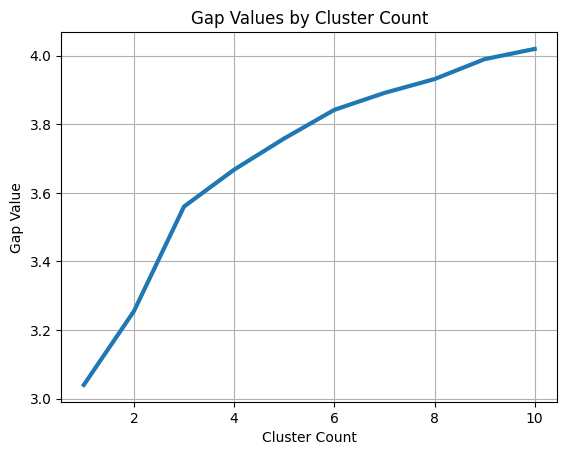

In [55]:
# Plotting the Gap Values
plt.plot([x + 1 for x in range(max_k)],results_gap_statistics[1], linewidth=3)
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

## Applying the optimal k value to the data

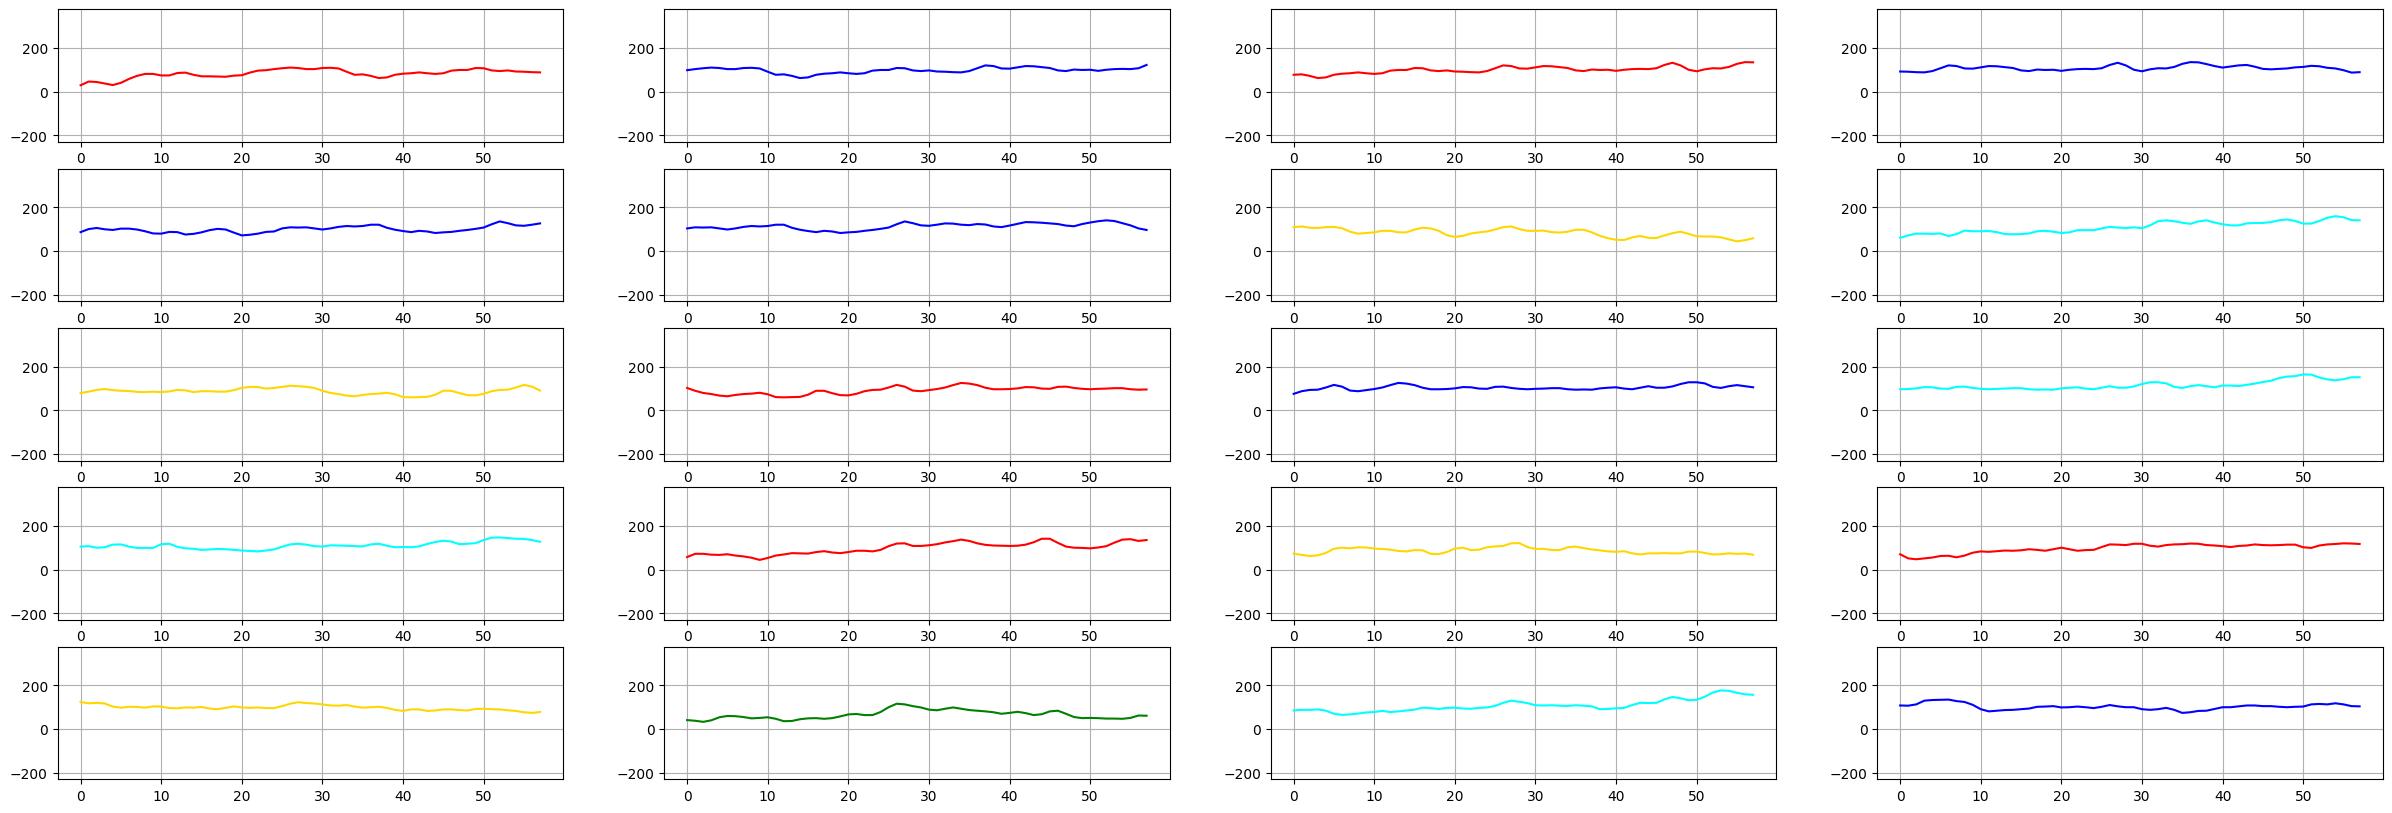

In [49]:
# apply final clustering algorithm based on optimal number of clusters
n_clusters = 6
kmeans_final = KMeans(n_init=10, n_clusters=n_clusters)
classes = kmeans_final.fit_predict(spikes)
colors = ['r', 'g', 'b',"aqua", "coral", "gold", "indigo", "khaki", "lavender", "magenta", "navy", "peru", "salmon"]

# plot first 20 spikes in different colors to see if clustering worked
plt.figure(figsize=(30, 10))
for i, spike in enumerate(spikes[:20]):
    plt.subplot(5, 4, i + 1)
    plt.grid()
    plt.ylim(ymin, ymax)
    plt.plot(spike, c=colors[classes[i]])
plt.show()

Other sources

1. https://towardsdatascience.com/k-means-clustering-and-the-gap-statistics-4c5d414acd29
2. https://github.com/Mavengence/Pattern_Analysis_SS20_FAU/blob/master/Exercise_6.ipynb
3. https://anaconda.org/milesgranger/gap-statistic/notebook?version=2016.04.25.1430Other 